# Star Trek Scripts - Getting the Dialogue and Analysis

A webscraping project collecting scripts from all Star Trek series (excl movies).

The project collects the data from the curated text on http://www.chakoteya.net/StarTrek/index.html. The raw scripts are then collected using the python requests module and stored in JSON format.

This project then processes each script into a further refined dataset by collating each line by each character per episode. This refined dataset is also made available in JSON format.

Finally, a sample analysis is provided with the processed data.

In [20]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
import json
import matplotlib.pyplot as plt

## Get the text and cast from an episode

To explore the approach, we'll first look at a single episode. In this case, the episode "What you leave behind" from Deep Space Nine. The script is here: 'http://www.chakoteya.net/DS9/575.htm'

The process uses the following procedures.

get_text:     gets the script text from a given url

clean_text:   cleans the script text 

get_cast:     gets the characters from that scrip

In [21]:
def get_text(url):
    response = requests.get(url)
    content = response.content
    parser = BeautifulSoup(content,'html.parser')
    return(parser.text)

In [192]:
def clean_text(script):
    script_clean=script.strip()
    script_clean=script_clean.replace("\n","")
    script_clean=script_clean.replace("\r"," ")
    script_clean=script_clean.replace("\r\n","")
    script_clean=re.sub("([\(\[]).*?([\)\]])", "", script_clean)
    script_clean=re.sub(r'\.([a-zA-Z])', r'. \1', script_clean) #remove missing whitespace between character lines.
    script_clean=re.sub(r'\!([a-zA-Z])', r'! \1', script_clean)
    script_clean=re.sub(r'\?([a-zA-Z])', r'? \1', script_clean)
    return(script_clean)

In [193]:
def get_cast(script_clean):
    tokens=nltk.word_tokenize(script_clean)
    cast=[]
    for word in tokens:
        if re.search("\\b[A-Z]{3,}\\b", word) is not None:
            cast.append(word)
    return(list(set(cast)))

In [194]:
script=get_text('http://www.chakoteya.net/DS9/575.htm')

In [195]:
script_clean=clean_text(script)

In [196]:
script_clean

"The Deep Space Nine Transcripts - What You Leave BehindWhatYou Leave BehindStardate:UnknownOriginal Airdate: 31 May, 1999   COMPUTER: Doctor Bashir. The time is oh fivehundred. BASHIR: Yeah, all right. EZRI: Julian. BASHIR: Yes. EZRI: We have to get up. BASHIR: Are you sure? EZRI: It's a big day. BASHIR: It was a big night. It cleared up a lot of unansweredquestions. EZRI: Such as? BASHIR: Such as just how far these spots really go down. EZRI: I suppose you'll want to tell Miles. BASHIR: Why would I want to do that? EZRI: Because you tell him everything. BASHIR: True, but you know what? In this case, I'm going to make anexception. EZRI: Good. Oh, we really should get up. We don't want the Defiantleaving without us. BASHIR: You know, I've never been into battle with someone I've sleptwith before. EZRI: There's a first time for everything. BASHIR: Now that we're finally together, it'd be such a shame ifsomething happened to one of us. EZRI: Let's make a pact. We both come home alive. BA

In [197]:
cast=get_cast(script_clean)

In [210]:
#cast

## Get all the lines for each character

The get_lines proc will get the lines for each character for that episode and store these in a dictionary.

In [202]:
def get_lines(script_clean, cast):
    split_script=script_clean.split(':')
    lines_dict=dict.fromkeys(cast)
    for cast_member in cast:
        lines=[]
        for i in range(len(split_script)-1):
            if cast_member in split_script[i].strip().split(" "):
                line=split_script[i+1].strip().split(" ")
                line=[word for word in line if word != '']
                for member in cast:
                    if member in line:
                        line.remove(member)
                line=' '.join(line)
                lines.append(line)
        lines_dict[cast_member]=lines

    return(lines_dict)

In [203]:
DS9_dict=get_lines(script_clean,cast)

In [204]:
DS9_dict['SISKO']

["How's that?",
 'Well, if it will help, morning sickness ends after the firsttrimester.',
 "You're going to make it.",
 'I promise.',
 'I said I promise.',
 'Come in.',
 "I'd like that.",
 "She doesn't like taking medication unless it's absolutelynecessary.",
 "You're sure I can't get you anything?",
 'All right people, what do you say we end this war?',
 'Ensign, I believe you know the way to Cardassia.',
 'Do you hear that, Chief?',
 "Ensign, how's she handling?",
 'Chief?',
 'I wish she were here, too, Constable.',
 "The Colonel's a survivor.",
 'And it will. Soon. One way or the other.',
 'Mother?',
 'Are you talking about the war?',
 "I don't intend to.",
 'The Prophets came to me in a vision',
 "I'm not sure. Only time will tell.",
 'Put them through.',
 'That the three of us would share a bottle of bloodwine onCardassia Prime.',
 "He knows it won't be. Sisko to all hands. Prepare to engage theenemy.",
 'So do you, Ensign.',
 'Mister Worf?',
 'Evasive action, pattern Delta.',
 '

# Collecting all Scripts and Processing

## Get the url for every episode

The url for each episode is slightly different and some pages contain links to other areas of the site. We first collect these urls and filter for non-relevant links so we're left with only urls to each script.

In [205]:
def get_page_links():
    top_links=["http://www.chakoteya.net/DS9/episodes.htm", 
                   "http://www.chakoteya.net/StarTrek/episodes.htm", 
                   "http://www.chakoteya.net/NextGen/episodes.htm", 
                   "http://www.chakoteya.net/Voyager/episode_listing.htm", 
                   "http://www.chakoteya.net/Enterprise/episodes.htm"]
    short_links=["http://www.chakoteya.net/DS9/", 
                   "http://www.chakoteya.net/StarTrek/", 
                   "http://www.chakoteya.net/NextGen/", 
                   "http://www.chakoteya.net/Voyager/", 
                   "http://www.chakoteya.net/Enterprise/"]
    links_list=[]
    names_list=[]
    for i, link in enumerate(top_links):
        response = requests.get(link)
        content = response.content
        parser = BeautifulSoup(content,'html.parser')
        urls = parser.find_all('a')
        for page in urls:
            links_list.append(short_links[i]+str(page.get('href')))
            name=page.text
            name=name.replace('\r\n',' ')
            names_list.append(name)
            
    
    links_to_remove=['http://www.chakoteya.net/Voyager/fortyseven.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS1-S3.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS4-S7.htm',
                     'http://www.chakoteya.net/Enterprise/fortyseven.htm',
                    ]
    links_list=[link for link in links_list if (link.endswith('.htm')) & (link not in links_to_remove)]
    
    return(links_list)

In [206]:
page_links=get_page_links()

In [207]:
print(len(page_links))

708


In [208]:
DS9_links = page_links[0:173]
TOS_links = page_links[173:253]
TAS_links = page_links[253:275]
TNG_links = page_links[275:451]
VOY_links = page_links[451:611]
ENT_links = page_links[611:]

links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

## Scrape and process all scripts from http://www.chakoteya.net/StarTrek/index.html

From all the urls for each series, scrape the raw scripts. This generates a dictionary for each series, a dictionary of each episode and its raw text script.


The processing stage will generate a dictionary of each series containing, for each episode, a dictionary of all lines spoken by each character.

Structure:

all_series_line={*series_name*:{*episode number*:{*character*:all_lines}}}

e.g.

all_series_lines['DS9']['episode 0']['SISKO']


## Scrape raw scripts

In [209]:
links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']
links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

all_series_scripts={}
for i,series in enumerate(links):
    series_name=str(links_names[i])
    print(series_name)
    all_series_scripts[series_name]={}
    episode_script={}
    all_cast=[]
    for j,link in enumerate(series):
        episode="episode "+str(j)
        text=get_text(link)
        episode_script[episode]=text
    all_series_scripts[series_name]=episode_script

print(all_series_scripts)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [211]:
with open('all_scripts_raw.json', 'w') as data:
    json.dump(all_series_scripts, data)

In [212]:
with open('all_scripts_raw.json', 'r') as data:
    all_scripts_raw = json.load(data)

In [226]:
#all_scripts_raw['DS9']['episode 0']

## Process data

Clean text, extract characters and compile lines.

In [214]:
links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']

all_series_lines={}
for i,series in enumerate(links_names):
    print(series)
    series_name=str(linkseries_name=str(links_names[i])s_names[i])
    all_series_lines[series_name]={}
    all_lines_dict={}
    all_cast=[]
    #for j,episode in enumerate(all_series_scripts[series]):
    for j,episode in enumerate(all_scripts_raw[series]):
        #script=all_series_scripts[series][episode]
        script=all_scripts_raw[series][episode]
        cleaned_script=clean_text(script)
        cast=get_cast(cleaned_script)
        for member in cast:
            if member not in all_cast:
                all_cast.append(member)
        lines_dict=get_lines(cleaned_script,all_cast)
        all_lines_dict[episode]=lines_dict
    all_series_lines[series]=all_lines_dict

print(all_series_lines)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [215]:
with open('all_series_lines.json', 'w') as data:
    json.dump(all_series_lines, data)

In [216]:
with open('all_series_lines.json', 'r') as data:
    all_series_lines = json.load(data)

In [217]:
all_series_lines['VOY']['episode 0']['JANEWAY']

['Tom Paris? Kathryn Janeway. I served with your father on theAl-Batani. I wonder if we could go somewhere and talk.',
 "About a job we'd like you to do for us.",
 "I've been told the Rehab Commission is very pleased with yourwork. They've given me their approval to discuss this matter with you.",
 'Your father taught me a great deal. I was his science officerduring the Orias expedition.',
 "I'm leaving on a mission to find a Maquis ship thatdisappeared in the Badlands a week ago.",
 'Really?',
 "You've never seen Voyager. We'd like you to come along.",
 "You know the territory better than anyone we've got.",
 "My Chief of Security was on board, undercover. He was supposedto report in twice during the last six days. He didn't.",
 'Maybe. That ship was under the command of another formerStarfleet officer, named Chakotay. I understand you knew him.',
 "The two of you didn't get along too well, I'm told.",
 'You help us find that ship, we help you at your next outmeetreview.',
 "Officiall

## First Analysis 

To start, let's have a look at the most lines delivered by each charater in Deep Space Nine.

From the processed dataset, generate counts of all lines spoken by each charater.

In [218]:
episodes=all_series_lines['DS9'].keys()

In [219]:
total_lines_counts={}
line_counts_by_episode={}
for i,ep in enumerate(episodes):
    episode="episode "+str(i)
    line_counts_by_episode[episode]={}
    for member in list(all_series_lines['DS9'][ep].keys()):
        line_counts_by_episode[episode][member]=len(all_series_lines['DS9'][ep][member])
        if member in total_lines_counts.keys():
            total_lines_counts[member]=total_lines_counts[member]+len(all_series_lines['DS9'][ep][member])
        else:
            total_lines_counts[member]=len(all_series_lines['DS9'][ep][member])

#print(total_lines_counts)
#print("")
#print(line_counts_by_episode)

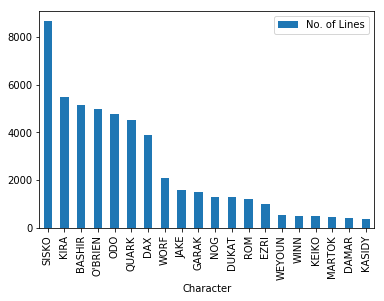

In [220]:
DS9_df=pd.DataFrame(list(total_lines_counts.items()), columns=['Character','No. of Lines'])
Top20=DS9_df.sort_values(by='No. of Lines', ascending=False).head(20)

Top20.plot.bar(x='Character',y='No. of Lines')
plt.show()